In [50]:
#importing Libraries
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img


# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

# Reading the Dataset


In [51]:
train_dir = 'archive/brain_dead_emotion_detection/Train/'
test_dir = 'archive/brain_dead_emotion_detection/Test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

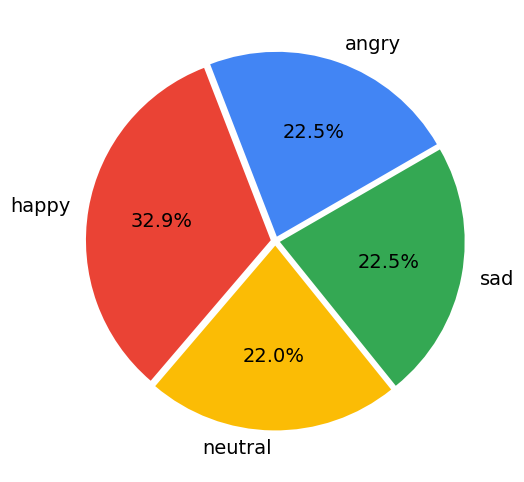

In [52]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='angry']),
         len([x for x in train_labels if x=='happy']),
         len([x for x in train_labels if x=='neutral']),
         len([x for x in train_labels if x=='sad'])],
        labels=['angry','happy', 'neutral', 'sad'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [53]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

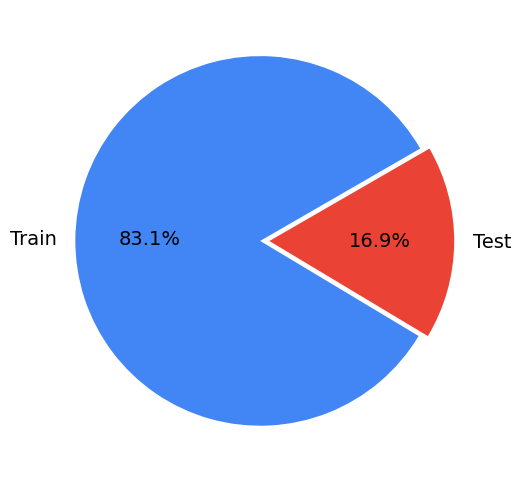

In [54]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# Data Augmentation

In [55]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

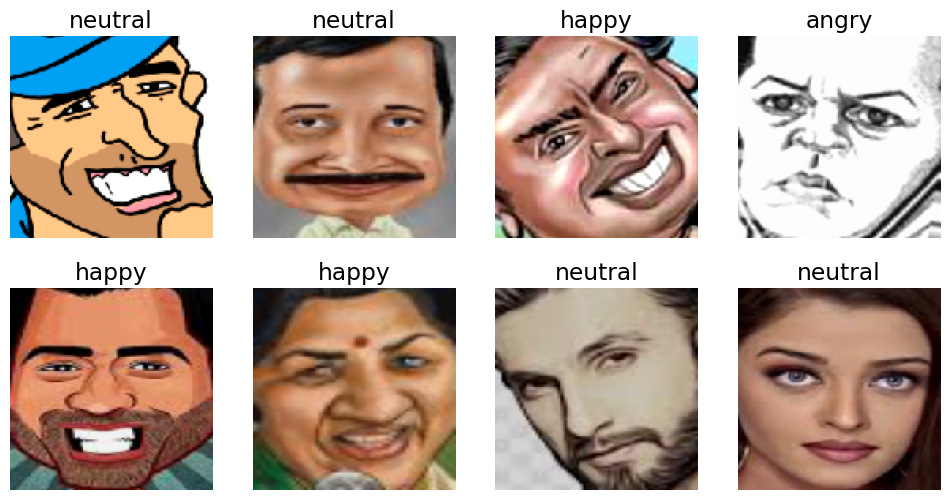

In [56]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# Data Generator

In [57]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# VGG16 Model

I am using Vgg16 for transfer learning

In [58]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [60]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [62]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model

In [63]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
90/90 [==============================] - 139s 2s/step - loss: 1.1405 - sparse_categorical_accuracy: 0.4883
Epoch 2/10
90/90 [==============================] - 145s 2s/step - loss: 0.6268 - sparse_categorical_accuracy: 0.7514
Epoch 3/10
90/90 [==============================] - 136s 2s/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8592
Epoch 4/10
90/90 [==============================] - 144s 2s/step - loss: 0.2566 - sparse_categorical_accuracy: 0.8955
Epoch 5/10
90/90 [==============================] - 147s 2s/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9268
Epoch 6/10
90/90 [==============================] - 146s 2s/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9503
Epoch 7/10
90/90 [==============================] - 146s 2s/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9637
Epoch 8/10
90/90 [==============================] - 145s 2s/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9693
Epoch 9/10
90/90 [==============================] - 143s

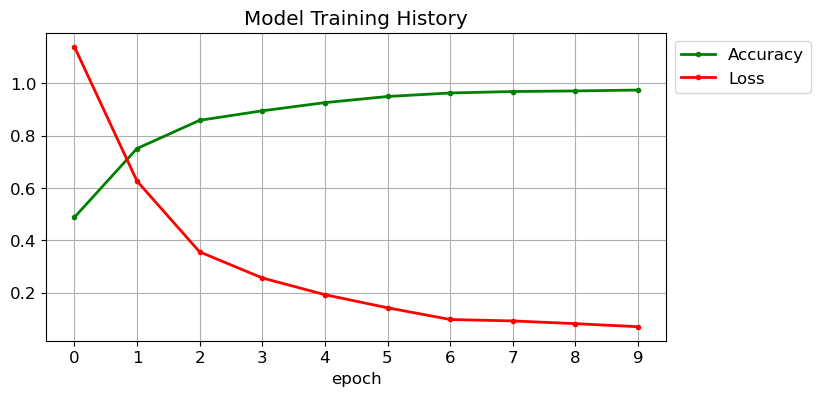

In [64]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Evaluate Model with Test Samples

In [65]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 2/11 [00:04<00:21,  2.41s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 3/11 [00:07<00:18,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 4/11 [00:09<00:15,  2.23s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 5/11 [00:11<00:13,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 6/11 [00:13<00:10,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 7/11 [00:15<00:08,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 8/11 [00:17<00:06,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 9/11 [00:19<00:03,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 10/11 [00:21<00:02,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 11/11 [00:23<00:00,  2.08s/it]

1/1 [==============================] - 1s 1s/step


12it [00:24,  2.07s/it]                        


In [66]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.53      0.61        80
       happy       0.73      0.70      0.71       105
     neutral       0.66      0.65      0.65       102
         sad       0.63      0.87      0.73        82

    accuracy                           0.68       369
   macro avg       0.69      0.68      0.68       369
weighted avg       0.69      0.68      0.68       369



In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()